# TP03 Exercise 1

Student names:
- Dan Yvan Baumgartner
- Jan Huber

## Imports

Import the necessary packages

In [1]:
import numpy as np             
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


## Reading the data

First, both the training data set and the test data set are read and stored as a _Pandas_ dataframe. Then, both data sets are separated into the actual data and the corresponding labels, and then stored in variables that will be used later. 

In [2]:
# Read the training data
csv_train = r'ex1-data-train.csv'
df_train = pd.read_csv(csv_train, header=None)

# Read the teat data
csv_test = r'ex1-data-test.csv'
df_test = pd.read_csv(csv_test, header=None)

# Separate the data from the labels of the training set
X_train = df_train.iloc[:, 0:2] # data
y_train = df_train.iloc[:, -1] # labels

# Separate the data from the labels of the test set
X_test = df_test.iloc[:, 0:2]
y_test = df_test.iloc[:, -1]


## Bayes

The class containing all the necessary methodes.


In [3]:
class Bayes:
    
    str_array = ["X1 failed", "X2 failed", "X1 passed", "X2 passed"]
    
    def __init_(self):
        pass
    
    
    def priori(self, y_train):
        """
        Calculate the "A Priori" probability P(Ck)

        Inputs:
        - y: An array of shape (N,) containing the training labels
        
        Returns:
        - P_priori: An array of shape (2,) containing the "A Priori" probabilities
          of both classes C0 (failed) and C1 (passed)
        """
        P_priori = np.zeros((2,))
        P_priori[0] = len(y_train[y_train == 0])/len(y_train) # failed
        P_priori[1] = len(y_train[y_train == 1])/len(y_train) # passed
        
        return P_priori
    
    
    def posteriori(self, X_test, X_train, y_train, naive=False, gauss=False):
        """
        Calculate the "A Posteriori" probability P(Ck|X)

        Inputs:
        - X_test: The test feature set
        - X_train: The training feature set
        - y_train: An array of shape (N,) containing the training labels
        - naive: A boolean value indicating if the naïve Bayes hypothesis
          should be applied
        - gauss: A boolean value indicating if a univariant gaussian distribution
          should be used instead of histograms
        
        Returns:
        - P_post: An array of shape (2, len(X_test)) containing the "A Posteriori" probabilities
          of both classes C0 (failed) and C1 (passed) for X_test
        """
        
        P_post = np.zeros((2, len(X_test)))  # [[P(C0|X)],[P(C1|X)]]
        
        if gauss:
            if naive:
                for Ck in range(2):
                    P_llh1 = self.likelihoodGauss(X_test[0], X_train[0], y_train, Ck)
                    P_llh2 = self.likelihoodGauss(X_test[1], X_train[1], y_train, Ck)
                    P_post[Ck] = P_llh1 * P_llh2 * self.priori(y_train)[Ck]
            else:
                for Ck in range(2):
                    P_llh = self.likelihoodGauss(X_test, X_train, y_train, Ck)
                    P_post[Ck] = P_llh * self.priori(y_train)[Ck] 
            
        else:
            if naive:
                for Ck in range(2):
                    P_llh1 = self.likelihood(X_test[0], X_train[0], y_train, Ck)
                    P_llh2 = self.likelihood(X_test[1], X_train[1], y_train, Ck) 
                    P_post[Ck] = P_llh1 * P_llh2 * self.priori(y_train)[Ck]
            else:
                for Ck in range(2):
                    P_llh = self.likelihood(X_test, X_train, y_train, Ck)
                    P_post[Ck] = P_llh * self.priori(y_train)[Ck]

        return P_post
    
    
    def likelihood(self, X_test, X_train, y_train, Ck):
        """
        Calculate the likelihood P(X|Ck) using histograms

        Inputs:
        - X_test: The test feature set
        - X_train: The training feature set
        - y_train: An array of shape (N,) containing the training labels
        - Ck: The label of the class, either 0 (failed) or 1 (passed)
        
        Returns:
        - P_llh: An array of shape (len(X_test),) containing the likelihoods
          of X_test for the specified class Ck
        """
        
        n, bins = np.histogram(X_train.loc[y_train == Ck], bins='auto')
        
        P_llh = []
        hist_prob = n/np.sum(n)
        
        for i in range(len(X_test)):
            bin_idx = np.argmax(X_test[i]<bins)
            P_llh = np.append(P_llh, hist_prob[bin_idx-1])

        return P_llh
    
    
    def likelihoodGauss(self, X_test, X_train, y_train, Ck):
        """
        Calculate the likelihood P(X|Ck) using a univariant gaussian distribution

        Inputs:
        - X_test: The test feature set
        - X_train: The training feature set
        - y_train: An array of shape (N,) containing the training labels
        - Ck: The label of the class, either 0 (failed) or 1 (passed)
        
        Returns:
        - P_llh: An array of shape (len(X_test),) containing the likelihoods
          of X_test for the specified class Ck
        """
        P_llh = []
        mean = np.mean(X_train)
        var = np.var(X_train)        
        X_train_Ck = np.sort(X_train.loc[y_train == Ck])
        
        gauss_prob = 1/(var * np.sqrt(2*np.pi)) * np.exp(-X_train_Ck - mean)**2 / (2*var**2)
        
        for i in range(len(X_test)):
            gauss_idx = np.argmax(X_test[i]<X_train_Ck)
            P_llh = np.append(P_llh, gauss_prob[gauss_idx])
        
        return P_llh
    
    
    def accuracy(self, P, y_test):
        """
        Calculate the accuracy of the predicted labels

        Inputs:
        - P: The "A Posteriori" probabilities P(Ck|X)
        - y_test: An array of shape (N,) containing the testing labels
        
        Returns:
        - acc: The accuracy of the prdicted labels      
        """
        
        y_pred = (P[0]<P[1]).astype(int) 

        acc = np.sum((y_pred==y_test).astype(int))/len(y_test)
        
        return acc
    
    
    def plotHist(self, X):
        """
        Plot the histograms for a given feature set

        Inputs:
        - X: A feature set
        """

        plt.figure(figsize=(10, 10))
        
        plot_num = 1
        
        for Ck in range(2):
            for i in range(2):
                plt.subplot(3, 2, plot_num)
                plt.title(self.str_array[plot_num-1])
                plot_num += 1

                n, bins, patches = plt.hist(X[i].loc[y_train == Ck], bins='auto')                



## Bayes - Histograms

**b) Computing the priors of both classes C0 (failed) and C1 (passed)**

In [4]:
by = Bayes()

Ck_fail = by.priori(y_train)[0]
Ck_pass = by.priori(y_train)[1]

print("A Priori probabilities:\n"
      "Ck = Failed: {}\n"
      "Ck = Passed: {}"
      .format(Ck_fail, Ck_pass))


A Priori probabilities:
Ck = Failed: 0.4
Ck = Passed: 0.6


**c) Plotting the histograms of X1 and X2 for both classes**

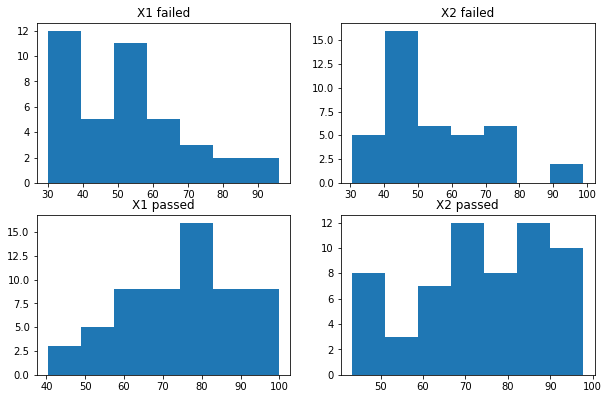

In [5]:
by.plotHist(X_train)

**e) Decision making and accuracy**

- Accuracy when only using X1: 66%
- Accuracy when only using X2: 61%
- Accuracy when using X1 and X1 and applying the naïve Bayes hypothesis: 72%

The accuracy of the system when the naïve Bayes hypothesis is applied, is higher than the accuracies obtained when only using one feature (either X1 or X2).
Nonetheless, the Bayes classification method when using histograms, is worse than the k-nn classifier for this data set. With fine-tuning of the Hyperparameter k, an accuracy of 97% can be achieved.

In [6]:
P1 = by.posteriori(X_test[0], X_train[0], y_train)
P2 = by.posteriori(X_test[1], X_train[1], y_train)
Pn = by.posteriori(X_test, X_train, y_train, naive=True)

acc1 = by.accuracy(P1, y_test)*100
acc2 = by.accuracy(P2, y_test)*100
accn = by.accuracy(Pn, y_test)*100

print("The accuracies of the Bayes classification system using histograms are:\n"
    "With X1: {:>9.2f}%\n"
    "With X2: {:>9.2f}%\n"
    "Naïve Bayes: {:>3.2f}%"
     .format(acc1, acc2, accn))


The accuracies of the Bayes classification system using histograms are:
With X1:     66.00%
With X2:     61.00%
Naïve Bayes: 72.00%


## Bayes - Univariate Gaussian distribution

- Accuracy when only using X1: 67%
- Accuracy when only using X2: 71%
- Accuracy when using X1 and X1 and applying the naïve Bayes hypothesis: 88%

The accuracies of this system when using a univariant gaussien distribution, is higher, especially when applying the naïve Bayes hypothesis.
But even when using this method, the Bayes classification method is still inferior to the k-nn classifier for this data set.

In [7]:
P1 = by.posteriori(X_test[0], X_train[0], y_train, gauss=True)
P2 = by.posteriori(X_test[1], X_train[1], y_train, gauss=True)
Pn = by.posteriori(X_test, X_train, y_train, naive=True, gauss=True)

acc1 = by.accuracy(P1, y_test)*100
acc2 = by.accuracy(P2, y_test)*100
accn = by.accuracy(Pn, y_test)*100

print("The accuracies of the Bayes classification system using a univariate Gaussian distribution are:\n"
    "With X1: {:>9.2f}%\n"
    "With X2: {:>9.2f}%\n"
    "Naïve Bayes: {:>3.2f}%"
     .format(acc1, acc2, accn))


The accuracies of the Bayes classification system using a univariate Gaussian distribution are:
With X1:     67.00%
With X2:     71.00%
Naïve Bayes: 88.00%
